# Defining a categorical scoring system

This notebook explores how we translate a continuous system of risk values into a 11-step categorical scoring system.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
query = duckdb.sql("""INSTALL httpfs; INSTALL spatial; load httpfs; load spatial;
SELECT wind_risk_2011, wind_risk_2047 FROM read_parquet('s3://carbonplan-ocr/output/fire-risk/vector/production/v0.7.0/geoparquet/consolidated-buildings.parquet')""")

In [3]:
df = query.to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

The distribution of risk values in this dataset is skewed with a very long tail at higher levels of risk. This skewed distribution can make it hard to distinguish both differences among risk levels at both higher and lower levels of risk. We overcome this, we design a scoring system with bins whose relative prevalence of buildings descend monotonically with increasing risk scores. This allows users to resolve fine scale differences risk in areas of low risk, while still distinguishing differences in areas with higher risk levels. To accomplish this 

Our approach is inspired by the WRC's increasingly fine quantile increments at higher levels of risk, as described in the supplemental materials for the Wildfire Risk to Communities project, specifically the `WRC_V2_DataPercentiles.xlsx` file found [here](https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0016-2). The WRC project uses "class breakpoints at 40th, 70th, 90th, and 95th percentile."  According to their documentation, that translates to breakpoints at the following values of RPS: `0.0188485, 0.0940430, 0.4081965, 0.7222983`. However, they based their percentiles and breakpoints on pixels as opposed to buildings, so they are in appropriate for us to use out-of-the-box. Given our focus on buildings, we will design our bins according to the distribuiton of risk values for buildings. 


First we calculate what fraction of buildings are 0's. This will determine the percentile of the first bin because anything with a score of 0 will be assigned a risk score of 0.

In [4]:
fraction_zero = (df[['wind_risk_2011']] == 0).sum() / len(df[['wind_risk_2011']])

Next, we divvy up the non-zero portion of the distribution, assigning 10 parts to risk score 1, 9 parts to risk score 2, .... and 1 part to risk score 10. (For anyone curious, this pattern borrows the concept of [triangle numbers](https://simple.wikipedia.org/wiki/Triangular_number) from number theory!)

In [5]:
total_distribution_units = 10 * (10 + 1) / 2  # calculate the 10th triangle number

The total range of quantiles we are divvying is the fraction of all buildings with a non-zero risk.

In [6]:
one_unit_of_distribution = (1 - fraction_zero.values[0]) / total_distribution_units

We then calculate the quantile for each of our bins by adding first adding 10 `units_of_distribution` onto the starting quantile, then 9, then 8... until the last quantile bin is only one unit (which will represent risk score 10). 

In [7]:
quantiles = [fraction_zero.values[0]]
for i in np.arange(0, 10):
    quantiles.append(quantiles[i] + one_unit_of_distribution * (10 - i))
bins = np.quantile(df[['wind_risk_2011']].values, quantiles[:-1])
bins = np.insert(bins, 0, 0, axis=0)
bins = np.insert(bins, 11, 100, axis=0)

As shown below, the bin breakpoints at higher risk levels are more spaced out (and more clustered at lower risk levels), while the corresponding quantiles are more clustered at higher risk levels and more spaced out at lower risk levels.

In [8]:
print(bins)
print(quantiles)

[0.00000000e+00 2.62412512e-03 1.52299161e-02 2.20563617e-02
 3.11328769e-02 4.38800976e-02 6.38942719e-02 9.68606608e-02
 1.53278274e-01 2.70271845e-01 5.67629545e-01 1.00000000e+02]
[np.float64(0.7375874811849557), np.float64(0.7852988482422364), np.float64(0.8282390785937891), np.float64(0.8664081722396137), np.float64(0.8998061291797103), np.float64(0.9284329494140787), np.float64(0.9522886329427191), np.float64(0.9713731797656314), np.float64(0.9856865898828157), np.float64(0.9952288632942718), np.float64(0.9999999999999999)]


All of this is probably easier shown than explained. When we use the bins calculated above to assign risk scores to the buildings in our dataset, the distribution of risk scores looks like below.

Text(0.5, 1.0, 'Counts of buildings in each score bin')

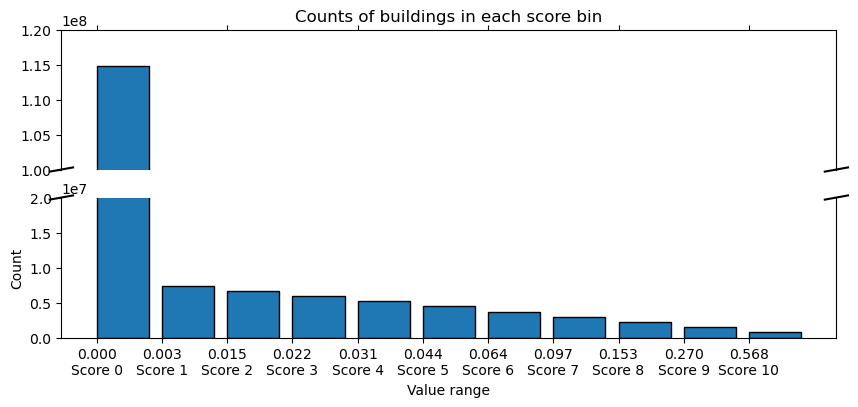

In [9]:
values = df['wind_risk_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
# plt.show()

Let's update the bin breakpoints to rounder numbers to support interpretability. Then, let's confirm that the rounding update still preserves general pattern of higher risk scores being less prevalent.

Text(0.5, 1.0, 'Counts of buildings in each score bin')

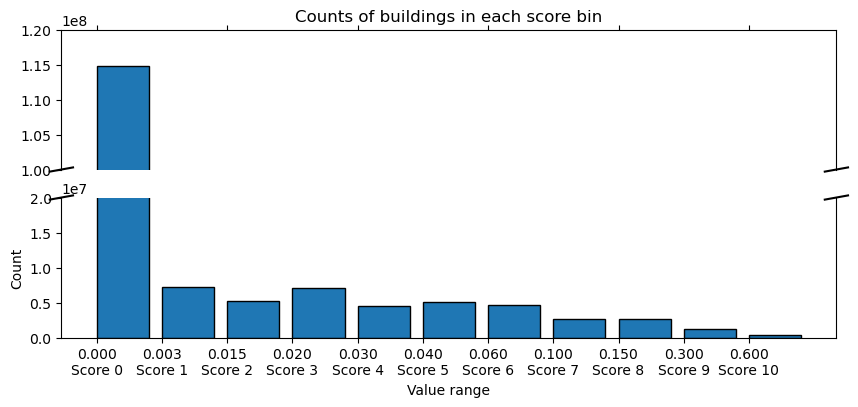

In [10]:
bins = [0, 0.003, 0.015, 0.02, 0.03, 0.04, 0.06, 0.1, 0.15, 0.3, 0.6, 1]
values = df['wind_risk_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
# plt.show()

Then let's see what the risk values look like for the future scenario.

Text(0.5, 1.0, 'Counts of buildings in each score bin')

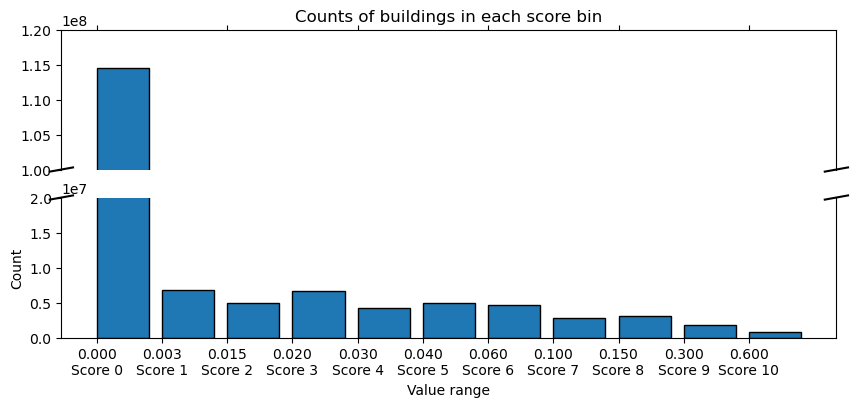

In [11]:
values = df['wind_risk_2047'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
# plt.show()